# Soluciones al examen de OPI 

In [86]:
# paquetes necesarios para este examen
import pandas as pd
from datetime import datetime # para que Python reconozca las fechas
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [346]:
# Función que se necesitará más adelante para agregar formato a la fec
def cambio_mes(mes):
    reemplazo = (
            ('Enero', '01'),
            ('Febrero', '02'),
            ('Marzo', '03'),
            ('Abril', '04'),
            ('Mayo', '05'),
            ('Junio','06'),
            ('Julio','07'),
            ('Agosto','08'),
            ('Septiembre','09'),
            ('Octubre', '10'),
            ('Noviembre','11'),
            ('Diciembre', '12')
        )
    for a, b in reemplazo:
        mes = mes.replace(a, b)
    return mes
cambio_mes.__doc__ = "Cambia el mes a su correspondiente valor numerico"

In [697]:
def seleccion_tiempo(rango, datos):
    comp = datos['ao_hechos'] >= str(int(datos['ao_hechos'][-1]) - rango)
    datos_aux = datos[comp]
    return datos_aux
seleccion_tiempo.__doc__ = "Se seleccionan los datos de los últimos años, de acuerdo al rango dado."

def regresion_lineal(rango,datos):
    datos = seleccion_tiempo(rango, datos)
    X = np.arange(len(datos.index))  # features
    y = datos['size']
    pendiente = linregress(X, y).slope
    return pendiente
regresion_lineal.__doc__ = "Regresa la pendiente de los datos seleccionados de acuerdo al rango de años dado."

def seleccion_delito(datos, lista):
    #comp = datos['delito'] == delito
    datos_aux = datos[datos['delito'] == lista]
    return datos_aux
seleccion_delito.__doc__ = "Se crea un subgrupo de los datos de acuerdo al delito elegido."

def alza_baja(rango, datos, lista):
    lista_aux = []
    lista_total = []
    for delito in lista:
        datos_aux = seleccion_delito(datos, delito)
        tiempo = seleccion_tiempo(rango, datos_aux)
        pendiente = regresion_lineal(rango, datos_aux)
        if pendiente > 0:
            lista_aux.append('Alza')
        else:
            lista_aux.append('Baja')
    lista_total = lista_total + lista_aux
    df = pd.DataFrame(lista_total)
    df.set_index(lista, inplace = True)
    df.columns = ['Tendencia durante los últimos '+ str(rango) + ' años']
    return df
alza_baja.__doc__ = "De acuerdo al rango de años dado, se muestra en un Data Frame la tendencia para cada uno de los delitos registrados."

1. Los datos son de calidad cuando sirven para una finalidad prevista, basados en las siguientes características:
* No debe haber huecos, ni variables repetidas.
* La información debe ser relevante para cumplir los objetivos, por ejemplo, si estoy haciendo un análisis sobre los delitos en la ciudad de México, no me sirve tener información sobre el peso de los habitantes de la ciudad.
* Confiabilidad: hay que asegurarse que los datos no sean ambiguos, vagos o que contengan información contradictoria, por ejemplo, si tengo información sobre los delitos de una alcaldía en dos columnas y cada una con información diferente.
* Los datos tienen que ser colectados en el tiempo correcto, hay que asegurarse que no sean obsoletos, tomando de nuevo el análisis de los delitos de la CDMX, no tendría sentido que sólo tenga información de hace 30 años.

2. Datos a la alza y a la baja.

In [25]:
# importamos la base de datos
# encoding='utf-8' es para que al importarse la base de datos, reconozca caracteres 
# como la ñ.
# dtype='unicode' es para evitar un warning por low_memory ya que python estaba 
# adivinando el tipo de objeto (dtype) de cada columna

datos = pd.read_csv('/home/lorena/Escritorio/OPI/carpetas_completa_febrero_2022.csv', encoding='utf-8', dtype='unicode')

Para que las columnas fecha_hechos y fecha_inicia tal cual sean reconocidas como fechas, se utiliza la función de pandas **to_datetime**.

In [30]:
datos['fecha_hechos'] = pd.to_datetime(datos['fecha_hechos'], format = "%Y %m %d %H:%M:%S")
datos['fecha_inicio'] = pd.to_datetime(datos['fecha_inicio'], format = "%Y %m %d %H:%M:%S")

In [241]:
datos.set_index(datos['mes_hechos']+'/'+datos['ao_hechos'], inplace = True)

In [28]:
datos.columns

Index(['ao_hechos', 'mes_hechos', 'fecha_hechos', 'ao_inicio', 'mes_inicio',
       'fecha_inicio', 'delito', 'fiscalia', 'agencia', 'unidad_investigacion',
       'categoria_delito', 'calle_hechos', 'calle_hechos2', 'colonia_hechos',
       'alcaldia_hechos', 'competencia', 'longitud', 'latitud', 'tempo'],
      dtype='object')

A continuación, descarto a aquellas filas en las que el año o la alcaldia de los hechos sea igual a **nan**:

In [725]:
es_nan_fecha = pd.isnull(datos['ao_hechos'])
es_nan_lugar = pd.isnull(datos['alcaldia_hechos'])
datos = datos[np.logical_not(np.logical_or(es_nan_fecha,es_nan_lugar))]

En el ejercicio se pide que se analice sólo los delitos ocurridos en la ciudad de México, así que el siguiente paso es descartar a aquellas locaciones que no pertenezcan a la ciudad.

Así que defino una función que seleccionará sólo a aquellos datos que hayan sido tomados en alguna alcaldía de la CDMX.

In [757]:
def seleccion_por_alcaldia(datos):
    
    alcaldias_cdmx = ['AZCAPOTZALCO', 'ALVARO OBREGON', 'BENITO JUAREZ', 'COYOACAN', 'CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO', 'IZTACALCO', 'IZTAPALAPA', 'LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA', 'TLALPAN','TLAHUAC','VENUSTIANO CARRANZA','XOCHIMILCO']
    
    lista = [locacion in alcaldias_cdmx for locacion in datos['alcaldia_hechos']]
        
    return datos[lista]

In [758]:
datos_por_alcaldia = seleccion_por_alcaldia(datos)

Con la base agrupada, y con las observaciones nulas para la fecha y la alcaldia; agruparé a la base por fecha, para así calcular cuantas veces ocurren los delitos de acuerdo al año y mes.

In [760]:
delitos_fr = datos.groupby(['delito','ao_hechos','mes_hechos'], as_index=False, group_keys=True).size()

En **delitos_fr** aplicamos la función **cambio_mes** para que fila a fila se cambie el formato del mes a numérico:

In [762]:
delitos_fr['mes_hechos'] = delitos_fr['mes_hechos'].apply(cambio_mes)

Para que sea más sencillos seleccionar la frecuencia de acuerdo al delito, hice una lista con el nombre de estos:

In [764]:
delitos = delitos_fr['delito'].unique()

Como índice para este nuevo DataFrame asignaré a la fecha, sólo año y mes, con esos dos datos temporales es suficiente en caso de que se requieran hacer gráficas.

In [767]:
delitos_fr.set_index(pd.to_datetime(delitos_fr['mes_hechos']+'/'+delitos_fr['ao_hechos'], format = '%m/%Y'), inplace = True)

## Prueba con un sólo delito

Antes de manipular los datos delito a delito, comencé con el primero del arreglo **delitos**. Así que primero seleccioné de **delitos_fr** el subgrupo del primer delito. 

In [769]:
primer_delito = delitos_fr[delitos_fr['delito'] == delitos[0]]

Para tener una idea de cómo se distribuyen los delitos a los largo del tiempo, se muestra la siguiente gráfica:

Hice una gráfica de la frecuencia para el primer delito, para confirmar que todo, está bien. **Nota**: más adelante si es necesario, quitaré esta gráfica.

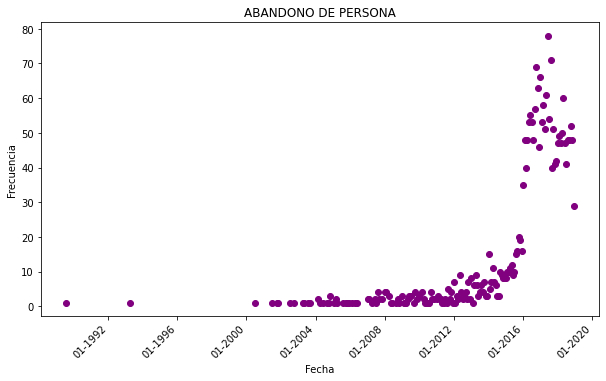

In [771]:
import matplotlib.dates as mdates # Intervalos de fecha
from matplotlib.dates import DateFormatter # para indicar el formato de fecha
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(primer_delito.index,
        primer_delito['size'],
        color='purple')
ax.set(xlabel="Fecha", ylabel="Frecuencia",
       title=delitos[0])

# Formato para el eje x
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
fig.autofmt_xdate(rotation=45)

plt.show()

### Regresion lineal 

Lo que queremos averiguar es si la ocurrencia de un delito ha ido a la alza o a la baja a lo largo del tiempo, esto se puede averiguar ajustando la ecuación de una recta a cada subgrupo de datos por delito, y una vez hecho, tomar el valor de la pendiente obtenida de esta ecuación; si la pendiente es positiva, quiere decir que hay una tendencia a la alta, en caso de ser negativa, la tendencia será a la baja.

### Rangos de tiempo 

En la gráfica de las ocurrencias del delito por abandono de persona, se observa que en los datos más viejos se tienen menos ocurrencias, así que si queremos analizar la tendencia con toda la base de datos, estas mediciones más viejas podrían darnos una idea errónea de lo que está ocurriendo. Para evitar eso, podemos revisar la tendencia en diferentes rangos de tiempo, por ejemplo, ver qué ha ocurrid 

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X = np.arange(len(primer_delito.index)).reshape((-1,1))  # features
y = primer_delito['size']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=primer_delito.index)

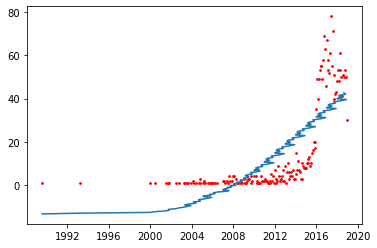

In [559]:
plt.plot(y_pred)
plt.scatter(primer_delito.index,primer_delito['size'], color = 'red', s = 3)
plt.show()

In [ ]:
tendencia_15 = alza_baja(15, delitos_fr, delitos)

In [701]:
tendencia_15

,Tendencia durante los últimos 15 años
ABANDONO DE PERSONA,Alza
ABORTO,Alza
ABUSO DE AUTORIDAD,Alza
ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA,Alza
ABUSO DE CONFIANZA,Alza
...,...
VIOLACION TUMULTUARIA,Alza
VIOLACION TUMULTUARIA EQUIPARADA,Alza
VIOLACION TUMULTUARIA EQUIPARADA POR CONOCIDO,Baja
VIOLACION Y ROBO DE VEHICULO,Baja


Abajo dejé algunos datos extras por si los necesito a futuro:

In [110]:
# arreglo con los años de los hechos que aparecen en la base de datos, sin repetir
año_hechos = datos['ao_hechos'].unique()

In [111]:
año_hechos

array(['2016', '2015', '2012', '2014', '2011', '2008', '2006', '2010',
       '2013', '2005', '2009', '1955', '2004', '2002', '1998', '1997',
       '1965', '2007', '2000', '1987', '1999', '1956', '2001', '1996',
       '1986', '1915', '1988', '2017', '2003', '1991', '1993', '1977',
       '1984', '1995', '1994', '1990', '1992', '1978', '1989', '1972',
       '2018', '2019', '1974', '1970', '1980', '1976', '1983', '1985',
       '1966', '1969', '1981', '1960', '1982', '1975', '1954', '1973',
       '1964', '1968', '1963', '1971', '1958', '1942', '1930', '1979',
       '1906', '1962', '1957', '2020', '1950', '1952', '2021', '1967',
       '1961', '1917', '2022'], dtype=object)

In [57]:
# arreglo con los años de inicio que aparecen en la base de datos, sin repetir
año_inicio = datos['ao_inicio'].unique()

In [58]:
año_inicio

array(['2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype=object)

3. Para averiguar el número de delitos por alcaldía, se puede agrupar la base de datos de acuerdo a la alcaldía, después, contar el número de delitos, así se encontrará a la que tiene mayor número de delitos y a la que tiene el número de delitos menor. 

In [708]:
datos_por_alcaldia = datos.groupby('alcaldia_hechos')

In [707]:
datos_por_alcaldia.size()

alcaldia_hechos
ABALA                                      1
ACAMBARO                                   3
ACAMBAY                                    5
ACAPULCO DE JUAREZ                        73
ACATLAN                                    3
                                          ..
ZINAPECUARO                                2
ZIRACUARETIRO                              1
ZITACUARO                                  5
ZITLALTEPEC DE TRINIDAD SANCHEZ SANTOS     1
ZUMPANGO                                  62
Length: 574, dtype: int64

In [709]:
datos['alcaldia_hechos'].unique()

array(['BENITO JUAREZ', 'IZTAPALAPA', 'CUAUHTEMOC', 'TLAHUAC',
       'IZTACALCO', 'GUSTAVO A MADERO', 'MIGUEL HIDALGO', 'TLALPAN',
       'ALVARO OBREGON', 'VENUSTIANO CARRANZA', 'AZCAPOTZALCO',
       'CUAJIMALPA DE MORELOS', 'COYOACAN', 'XOCHIMILCO',
       'LA MAGDALENA CONTRERAS', 'MILPA ALTA', 'TLALNEPANTLA DE BAZ',
       'VERACRUZ', 'IXCATEOPAN DE CUAUHTEMOC', 'TUXPAM', 'HUIXQUILUCAN',
       'OCOYOACAC', 'ECATEPEC DE MORELOS', nan, 'SIN DATO', 'TULTEPEC',
       'ACATZINGO', 'GUELATAO DE JUAREZ', 'HERMOSILLO', 'ENSENADA',
       'IXTAPALUCA', 'NAUCALPAN DE JUAREZ', 'NEZAHUALCOYOTL', 'CHALCO',
       'TLATLAYA', 'SAN JUAN GUICHICOVI', 'ZAPOPAN',
       'SAN PEDRO IXTLAHUACA', 'NICOLAS ROMERO', 'VICTORIA', 'CULIACAN',
       'VALLE DE CHALCO SOLIDARIDAD', 'TIANGUISTENCO', 'TEHUACAN',
       'ACAPULCO DE JUAREZ', 'TEMASCALCINGO', 'CUAUTITLAN IZCALLI',
       'TIJUANA', 'CUERNAVACA', 'TENANGO DEL VALLE',
       'TULANCINGO DE BRAVO', 'CORREGIDORA', 'JUAREZ HIDALGO', 'CELAYA',
    